## Import libraries:

In [13]:
from imports import *

In [14]:
image = np.load("/data/vidales/images/image_realistic_4comp_bunch_centered_v2701.npy")

In [15]:
table = pq.read_table('/home/vidales/AI_nuvT/saved_archives/ophit_variables_bunch_centered_v2701.parquet')
nuvT_c_bunch = ak.from_iter(table.column('nuvT_c_bunch').to_pylist())
del table

In [16]:
nuvT_c_np = nuvT_c_bunch.to_numpy()
nuvT_c_sin = np.sin(2 * np.pi * nuvT_c_np / 19)
nuvT_c_cos = np.cos(2 * np.pi * nuvT_c_np / 19)

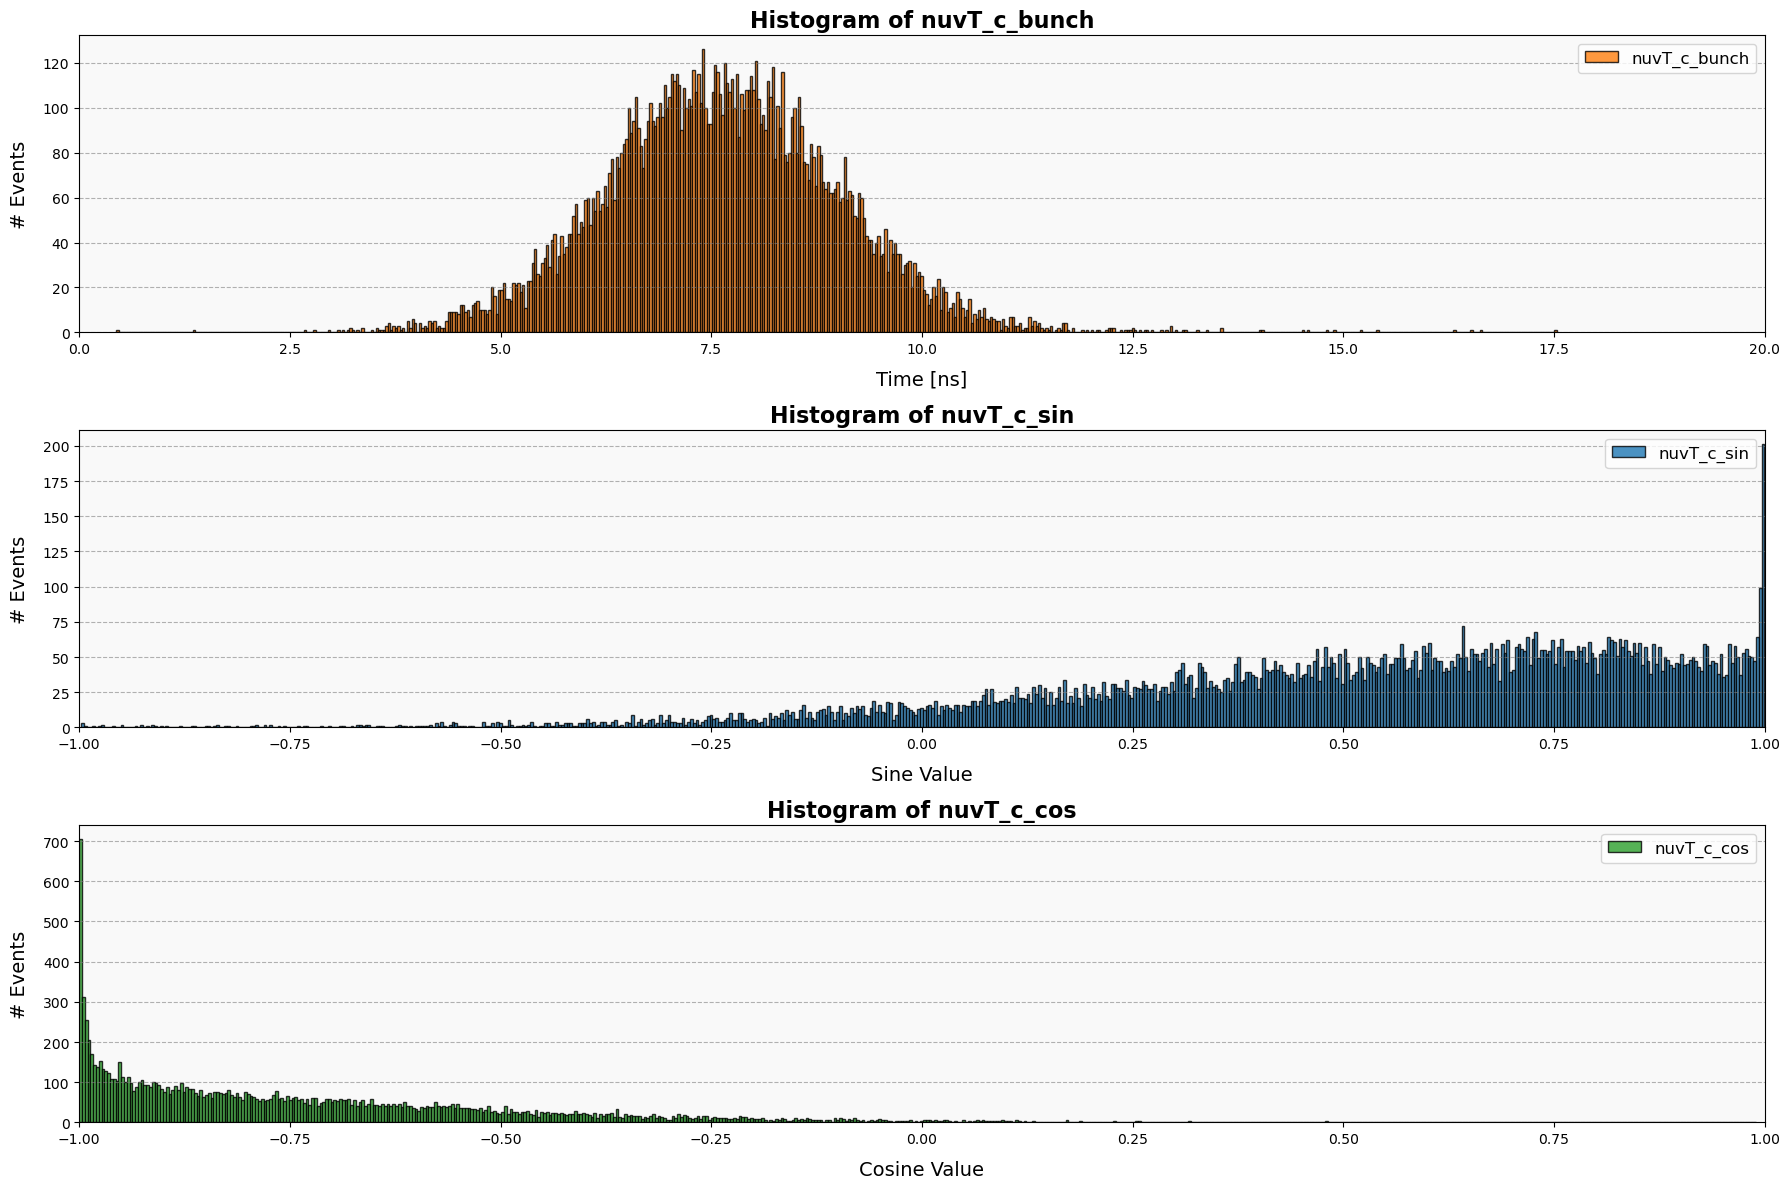

In [17]:
# Set up the plot
plt.figure(figsize=(18, 12))

# Histogram for nuvT_c_bunch
plt.subplot(3, 1, 1)
plt.hist(nuvT_c_bunch, bins=600, color='#ff7f0e', edgecolor='black', alpha=0.8, label='nuvT_c_bunch')
plt.title('Histogram of nuvT_c_bunch', fontsize=16, fontweight='bold')
plt.xlabel('Time [ns]', fontsize=14, labelpad=10)
plt.ylabel('# Events', fontsize=14, labelpad=10)
plt.xlim(0, 20)
plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
plt.legend(fontsize=12)
plt.gca().set_facecolor('#f9f9f9')

# Histogram for y_sin test
plt.subplot(3, 1, 2)
plt.hist(nuvT_c_sin, bins=600, color='#1f77b4', edgecolor='black', alpha=0.8, label='nuvT_c_sin')
plt.title('Histogram of nuvT_c_sin', fontsize=16, fontweight='bold')
plt.xlabel('Sine Value', fontsize=14, labelpad=10)
plt.ylabel('# Events', fontsize=14, labelpad=10)
plt.xlim(-1, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
plt.legend(fontsize=12)
plt.gca().set_facecolor('#f9f9f9')

# Histogram for nuvT_c_cos
plt.subplot(3, 1, 3)
plt.hist(nuvT_c_cos, bins=600, color='#2ca02c', edgecolor='black', alpha=0.8, label='nuvT_c_cos')
plt.title('Histogram of nuvT_c_cos', fontsize=16, fontweight='bold')
plt.xlabel('Cosine Value', fontsize=14, labelpad=10)
plt.ylabel('# Events', fontsize=14, labelpad=10)
plt.xlim(-1, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
plt.legend(fontsize=12)
plt.gca().set_facecolor('#f9f9f9')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [18]:
def create_cnn_model(x_train, conv_dim):

    from tensorflow.keras import layers, models
    from tensorflow.keras.callbacks import ModelCheckpoint
    """
    Creates a CNN model based on the provided architecture.
    
    Parameters:
    - input_shape: tuple, the shape of the input data (excluding batch size).
    
    Returns:
    - model: A compiled CNN model.
    """
    # Input layer
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    input_layer = layers.Input(shape=input_shape)
    
    # First convolutional block
    model = layers.Conv2D(32, conv_dim, padding='same')(input_layer)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)
    
    # Second convolutional block
    model = layers.Conv2D(64, conv_dim, padding='same')(model)
    model = layers.BatchNormalization()(input_layer)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)

    # Third convolutional block
    model = layers.Conv2D(128, conv_dim, padding='same')(model)
    model = layers.BatchNormalization()(input_layer)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)

    # Fourth convolutional block
    model = layers.Conv2D(256, conv_dim, padding='same')(model)
    model = layers.BatchNormalization()(input_layer)
    model = layers.LeakyReLU(alpha=0.1)(model)

    # Flatten the output and pass through dense layers
    model = layers.Flatten()(model)
    model = layers.Dense(1024, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(512, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(256, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(128, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    
    
    # Output layers for sin and cos
    output_sin = layers.Dense(1, activation='linear', name='sin_output')(model)
    output_cos = layers.Dense(1, activation='linear', name='cos_output')(model)

 
    # Create the model
    
    model_def = models.Model(inputs=input_layer, outputs=[output_sin, output_cos])

    # Custom Huber Loss function

    import tensorflow_probability as tfp
    def gaussian_nll_loss(y_true, y_pred):
        dist = tfp.distributions.Normal(loc=y_pred, scale=1.0)  # Assume fixed variance
        return -tf.reduce_mean(dist.log_prob(y_true))
    
    model_def.compile(optimizer='adam', 
                  loss={'sin_output': gaussian_nll_loss, 'cos_output': gaussian_nll_loss}, 
                  metrics=['mse'])

    return model_def

In [19]:
test_size = int(np.floor(0.10*np.shape(nuvT_c_sin)[0]) )
print(test_size)

1304


In [20]:
# prueba (los mapas originales están invertidos en y)
# Invert along the 59 dimension (axis 1)
inverted_image = image[:, ::-1, :, :]

In [21]:
x_train, x_test = inverted_image[:-test_size], inverted_image[-test_size:]
print('x_train dim.:',x_train.shape)
print('x_test dim.:', x_test.shape)

x_train dim.: (11744, 59, 70, 16)
x_test dim.: (1304, 59, 70, 16)


In [22]:
nuvT_c_train, nuvT_c_test = nuvT_c_np[:-test_size], nuvT_c_np[-test_size:]
y_sin_train, y_sin_test = nuvT_c_sin[:-test_size], nuvT_c_sin[-test_size:]
y_cos_train, y_cos_test = nuvT_c_cos[:-test_size], nuvT_c_cos[-test_size:]

In [23]:
model = create_cnn_model(x_train, (7,7))

In [24]:
history = model.fit(x_train, 
                        {'sin_output': y_sin_train, 'cos_output': y_cos_train},
                        validation_data=(x_test, {'sin_output': y_sin_test, 'cos_output': y_cos_test}),
                        epochs=20, batch_size=32)

Epoch 1/20
367/367 [==============================] - 7s 15ms/step - loss: 2.0116 - sin_output_loss: 1.0109 - cos_output_loss: 1.0007 - sin_output_mse: 0.1838 - cos_output_mse: 0.1636 - val_loss: 1.9635 - val_sin_output_loss: 0.9886 - val_cos_output_loss: 0.9748 - val_sin_output_mse: 0.1394 - val_cos_output_mse: 0.1118
Epoch 2/20
367/367 [==============================] - 5s 13ms/step - loss: 1.9415 - sin_output_loss: 0.9811 - cos_output_loss: 0.9603 - sin_output_mse: 0.1244 - cos_output_mse: 0.0828 - val_loss: 1.9359 - val_sin_output_loss: 0.9805 - val_cos_output_loss: 0.9554 - val_sin_output_mse: 0.1232 - val_cos_output_mse: 0.0729
Epoch 3/20
367/367 [==============================] - 5s 13ms/step - loss: 1.9342 - sin_output_loss: 0.9792 - cos_output_loss: 0.9550 - sin_output_mse: 0.1205 - cos_output_mse: 0.0721 - val_loss: 1.9352 - val_sin_output_loss: 0.9799 - val_cos_output_loss: 0.9553 - val_sin_output_mse: 0.1218 - val_cos_output_mse: 0.0727
Epoch 4/20
367/367 [=================

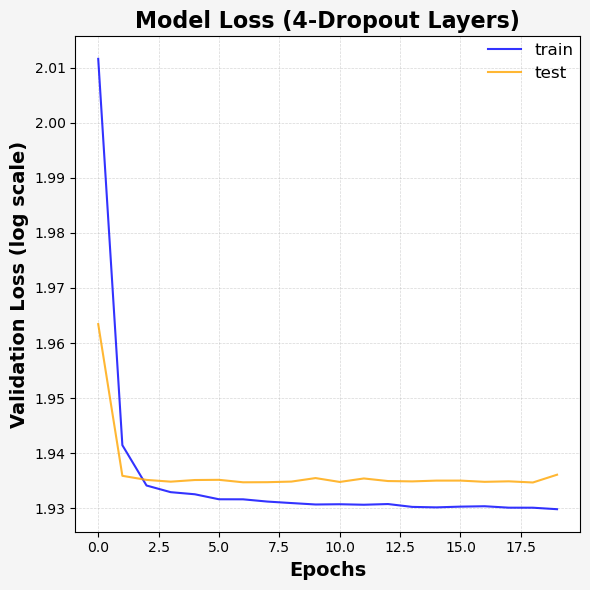

In [25]:
import matplotlib.pyplot as plt

# Access each model's history
model_history = history.history

# Plotting the validation loss for all models
plt.figure(figsize=(6, 6))

# Plot each model's validation loss with smooth lines, subtle markers, and refined styling
plt.plot(model_history['loss'], label='train', color='blue', linestyle='-', markersize=8, alpha=0.8)
plt.plot(model_history['val_loss'], label='test', color='orange', linestyle='-', markersize=8, alpha=0.8)

# Enhance plot appearance
#plt.yscale('log')  # Use logarithmic scale on y-axis
#plt.ylim()
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Validation Loss (log scale)', fontsize=14, fontweight='bold')
plt.title('Model Loss (4-Dropout Layers)', fontsize=16, fontweight='bold')
#plt.ylim(0.1,0.3)
# Refined grid with lighter lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Add legend with better positioning and larger font
plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0., frameon=False)

# Add background color for plot to make it stand out
plt.gcf().set_facecolor('whitesmoke')

# Show plot with a tight layout to avoid clipping
plt.tight_layout()
plt.show()


In [26]:
predictions = model.predict(x_test)

# Assuming predictions is a list of arrays where:
# predictions[0] is the sine predictions (predicted_sin)
# predictions[1] is the cosine predictions (predicted_cos)

predicted_sin = predictions[0].flatten()  # Flatten to make it easier for plotting
predicted_cos = predictions[1].flatten()

In [27]:
nuvT_c_sin_predicted = (np.arcsin(predicted_sin) * 19) / (2 * np.pi)
nuvT_c_cos_predicted = (np.arccos(predicted_cos) * 19) / (2 * np.pi)

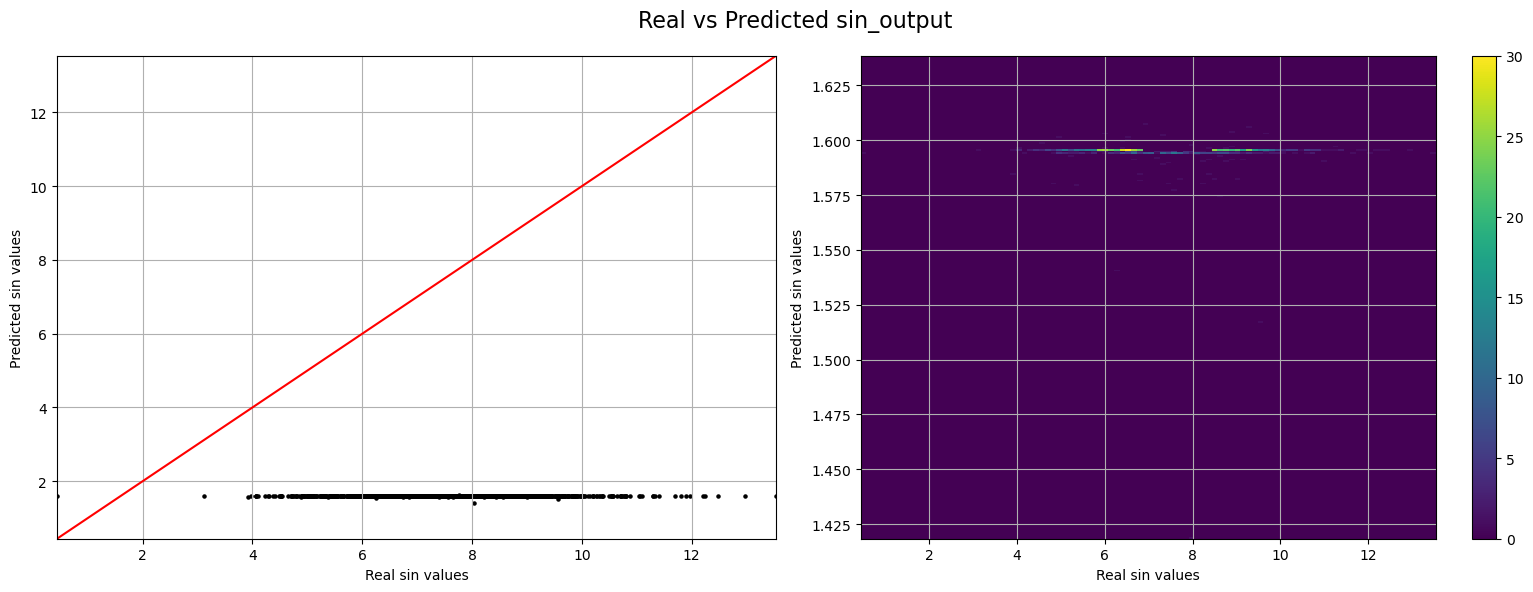

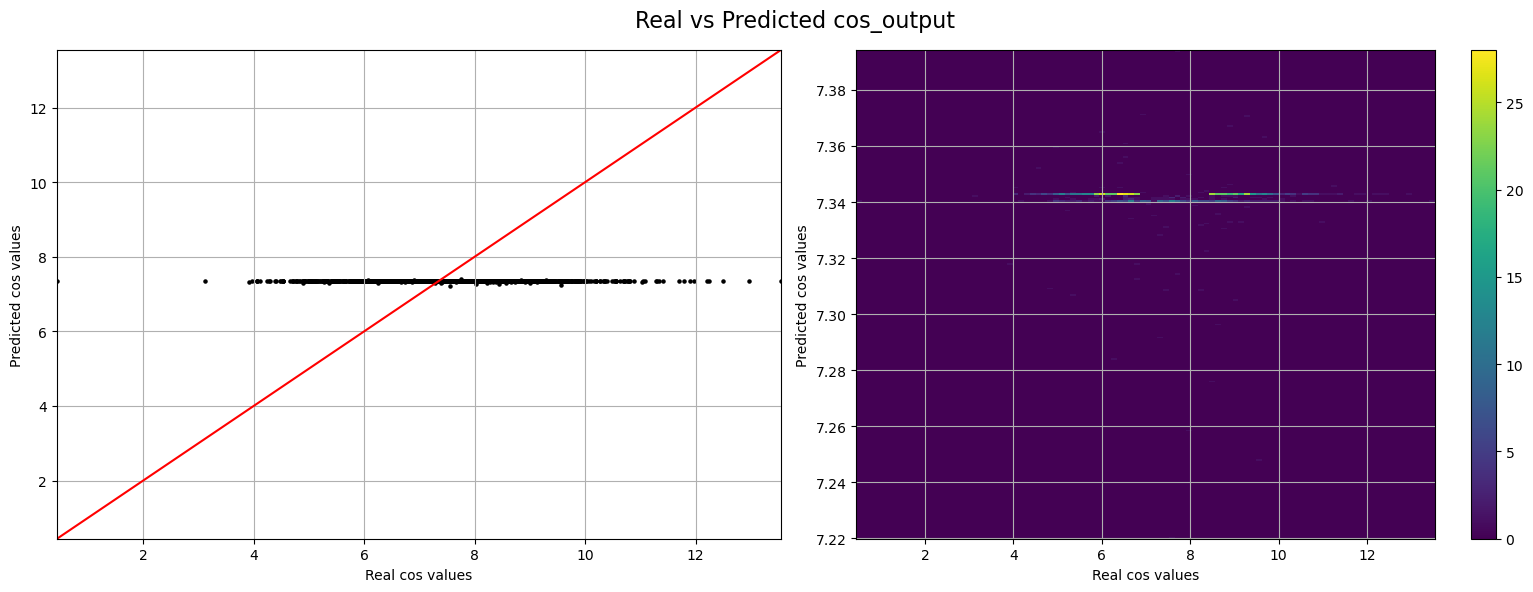

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming nuvT_c_test, nuvT_c_test, nuvT_c_sin_predicted , nuvT_c_cos_predicted  are numpy arrays
# Create the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Scatter Plot for Sin
axs[0].scatter(nuvT_c_test, nuvT_c_sin_predicted , color="black", s=5)
axs[0].grid()
axs[0].plot([min(nuvT_c_test.min(), nuvT_c_sin_predicted .min()), max(nuvT_c_test.max(), nuvT_c_sin_predicted .max())],
            [min(nuvT_c_test.min(), nuvT_c_sin_predicted .min()), max(nuvT_c_test.max(), nuvT_c_sin_predicted .max())], color="r")
axs[0].set_xlim([min(nuvT_c_test.min(), nuvT_c_sin_predicted .min()), max(nuvT_c_test.max(), nuvT_c_sin_predicted .max())])
axs[0].set_ylim([min(nuvT_c_test.min(), nuvT_c_sin_predicted .min()), max(nuvT_c_test.max(), nuvT_c_sin_predicted .max())])
axs[0].set_ylabel('Predicted sin values')
axs[0].set_xlabel('Real sin values')

# 2D Histogram for Sin
im0 = axs[1].hist2d(nuvT_c_test.flatten(), nuvT_c_sin_predicted .flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im0[3], ax=axs[1])
axs[1].grid()
axs[1].set_ylabel('Predicted sin values')
axs[1].set_xlabel('Real sin values')
axs[1].set_facecolor('#440154')

# Adjust layout and show the plot
fig.suptitle('Real vs Predicted sin_output', fontsize=16)
fig.tight_layout()
plt.show()

# Repeat the same steps for the cos values if needed
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Scatter Plot for Cos
axs[0].scatter(nuvT_c_test, nuvT_c_cos_predicted , color="black", s=5)
axs[0].grid()
axs[0].plot([min(nuvT_c_test.min(), nuvT_c_cos_predicted .min()), max(nuvT_c_test.max(), nuvT_c_cos_predicted .max())],
            [min(nuvT_c_test.min(), nuvT_c_cos_predicted .min()), max(nuvT_c_test.max(), nuvT_c_cos_predicted .max())], color="r")
axs[0].set_xlim([min(nuvT_c_test.min(), nuvT_c_cos_predicted .min()), max(nuvT_c_test.max(), nuvT_c_cos_predicted .max())])
axs[0].set_ylim([min(nuvT_c_test.min(), nuvT_c_cos_predicted .min()), max(nuvT_c_test.max(), nuvT_c_cos_predicted .max())])
axs[0].set_ylabel('Predicted cos values')
axs[0].set_xlabel('Real cos values')

# 2D Histogram for Cos
im1 = axs[1].hist2d(nuvT_c_test.flatten(), nuvT_c_cos_predicted .flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im1[3], ax=axs[1])
axs[1].grid()
axs[1].set_ylabel('Predicted cos values')
axs[1].set_xlabel('Real cos values')
axs[1].set_facecolor('#440154')

# Adjust layout and show the plot
fig.suptitle('Real vs Predicted cos_output', fontsize=16)
fig.tight_layout()
plt.show()
